## Calculate a temperature profile for a pure-steam case

### Import things
This assumes that SOCRATES is installed at `AGNI/socrates/`. Modify this as required.

In [1]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../"))
ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")

"/Users/nichollsh/Projects/AGNI/socrates"

In [2]:
# Import system packages
using Printf
using DelimitedFiles
using Plots

# Import AGNI
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.solver as nl
import AGNI.plotting as plotting

# Disable logging from AGNI module
AGNI.setup_logging("",false)

### Define atmosphere parameters

In [3]:
# Configuration options
instellation    = 1000.0  # Solar flux [W m-2]
gravity         = 9.81
radius          = 6.0e6
nlev_centre     = 60
p_surf          = 700.0     # bar
t_surf          = 2000.0
p_top           = 1e-6      # bar 
mole_fractions  = Dict([("H2O", 1.0)])

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/Dayspring/16/Dayspring.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt");


In [4]:
# Create output directory
output_dir = "/tmp/agni_notebook/"
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

### Initialise the atmosphere

In [5]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir, 
                        spectral_file,
                        instellation, 1.0, 0.0, 48.19,
                        t_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mf_dict=mole_fractions,
                        flag_gcontinuum=true,
                        thermo_functions=false
                        )
atmosphere.allocate!(atmos, star_file)

[ INFO  ] Composition set by dict 
[ INFO  ]     added gas H2O 
[ INFO  ] Inserting stellar spectrum 


### Run the model
The model iterates using the Newton-Raphson method, constructing a jacobian using finite-differences.    
Each line printed by this function provides information on convergence and other behaviours.

In [6]:
solver_success = nl.solve_energy!(atmos, 
                                    sol_type=3,         # Tell the model to solve for a state with zero net flux transport
                                    sens_heat=true,     # Include sensible heat transport
                                    method=1,           # Use the Newton-Raphson method
                                    dx_max=300.0,       # Allow large step sizes because of the poor initial guess
                                    linesearch=false,   # Disable Linesearch
                                    modplot=1,          # Disable live-plotting 
                                    save_frames=false   # ^
                                    )
println("Solver success? $solver_success")

[ INFO  ]     sol_type = 3 
[ INFO  ]     tmp_eff  = 0.00 K 
[ INFO  ]     f_eff    = 0.00 W m-2 
[ INFO  ]     step  resid_med  resid_2nm  flux_OLR   xvals_med  xvals_max  |dx|_max   flags 
[ INFO  ]        1  -9.23e+02  5.332e+05  5.226e+05  +1.79e+03  +1.91e+03  3.000e+02  C2-Nr 
[ INFO  ]        2  -9.90e+02  3.019e+05  2.964e+05  +1.59e+03  +1.89e+03  3.000e+02  C2-Nr 
[ INFO  ]        3  -1.09e+03  1.795e+05  1.765e+05  +1.41e+03  +1.87e+03  3.000e+02  C2-Nr 
[ INFO  ]        4  -2.55e+02  1.099e+05  1.083e+05  +1.28e+03  +1.87e+03  3.000e+02  C2-Nr 
[ INFO  ]        5  -2.01e+02  3.205e+05  5.663e+04  +1.15e+03  +1.88e+03  3.000e+02  C2-Nr 
[ INFO  ]        6  -2.00e+02  1.500e+07  2.506e+04  +9.97e+02  +1.87e+03  3.000e+02  C2-Nr 
[ INFO  ]        7  -5.90e+01  6.330e+07  9.247e+03  +8.52e+02  +1.85e+03  3.000e+02  C2-Nr 
[ INFO  ]        8  -4.51e+01  1.961e+07  3.329e+03  +7.27e+02  +1.85e+03  1.487e+02  C2-Nr 
[ INFO  ]        9  -2.67e+01  3.618e+06  1.407e+03  +5.97e+02  +

The first three lines show information about what the solver has been asked to model.    
In this case, we are modelling an atmosphere with zero net flux transport $F_{\text{eff}} = 0$.   
The following lines print information at each solver step. These columns are...
* Step number
* Median of all residuals
* Norm of all residuals (this is what the solver is attempting to minimise - the 'cost')
* Outgoing longwave radiation at the top of the atmosphere 
* Median of all x-values (temperatures)
* Maximum of all x-values
* Maximum step size across all levels in this iteration
* Flags describing what the solver did in order to evolve the model in this iteration   
 
Note that the cost initially increases, but after iteration #7 it decreases very rapidly.

### Analysing the output
The functions inside the `plotting` module can be used to write plots to files, but they also display inside this notebook.    

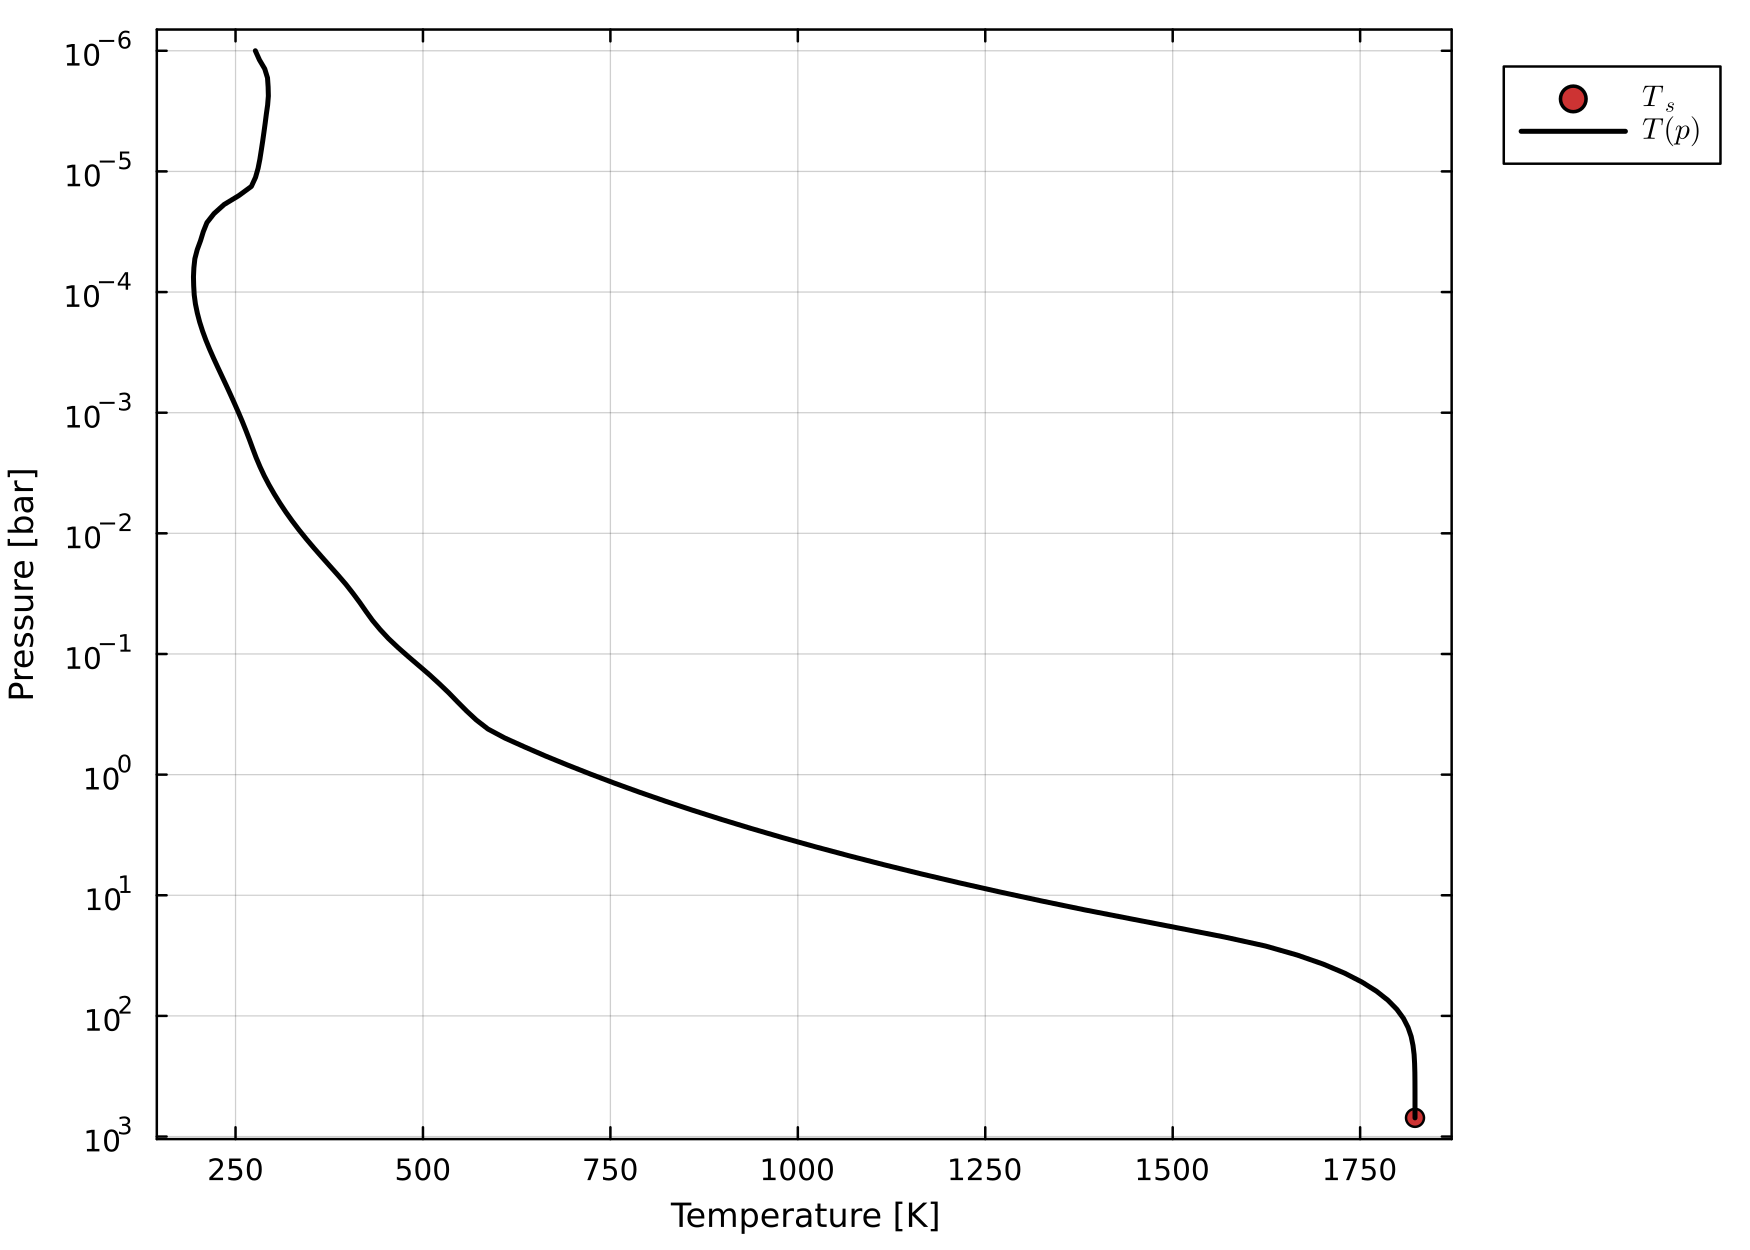

In [7]:
# Show the converged temperature profile
plt = plotting.plot_pt(atmos, "", size_x=700,size_y=500)

There are a few notable features:
* An isothermal layer is formed near the surface. The atmosphere is optically thick in this region, so a small temperature gradient is required in order to satisfy the zero-flux condition.
* Convection occurs between ~30 bar and ~1 bar.
* The atmosphere is purely radiative above 1 bar, with an inversion formed at pressures less than 0.1 mbar.
* The temperature becomes very small in the upper atmosphere, because condensation is  disabled.

Now, what about the fluxes?
We can plot these in a similar manner...

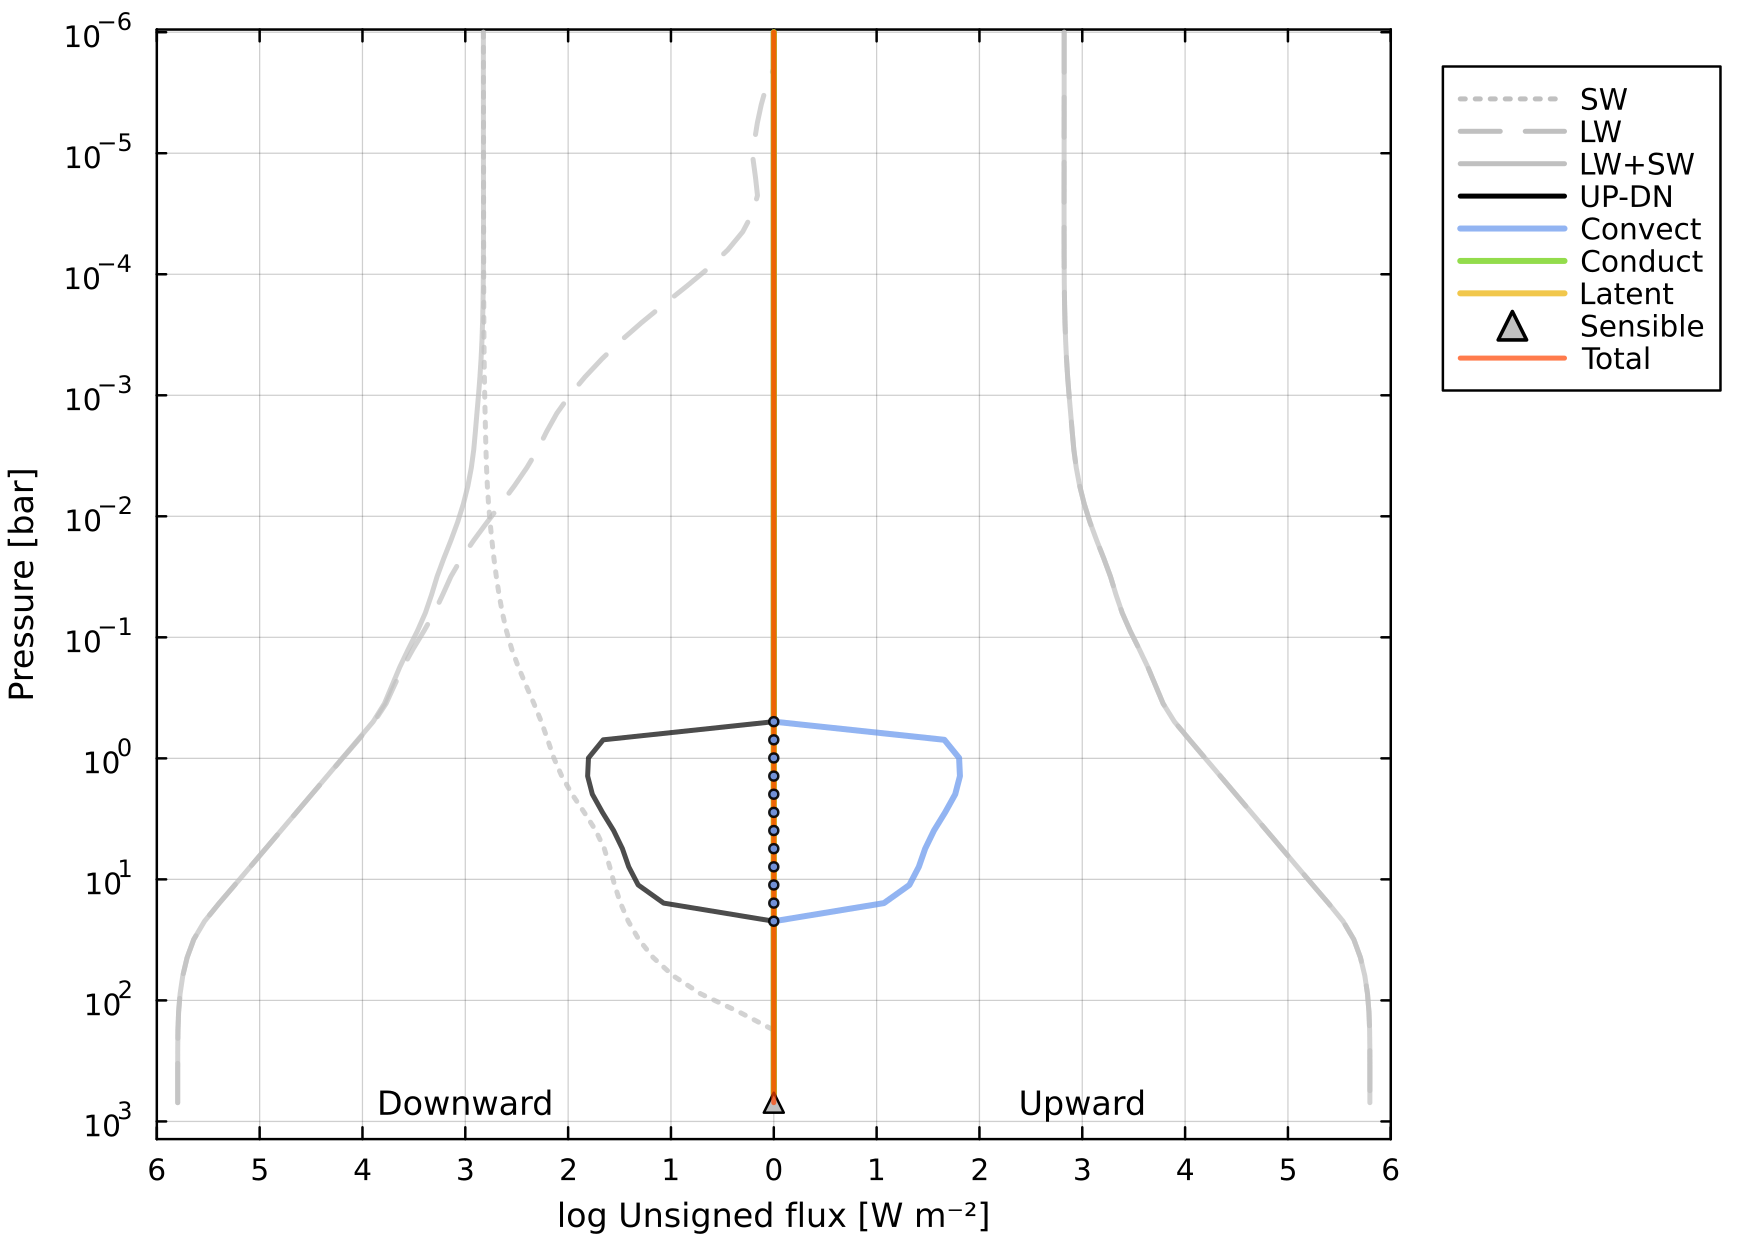

In [8]:
# Show the converged fluxes 
plt = plotting.plot_fluxes(atmos, "", size_x=700,size_y=500)

This plot shows the upward (right) and downward (left) flux components. Note the log scale on the x-axis.   
We can see that the convective and radiative fluxes add to zero in the region of dry convection.    
Rayleigh scattering is turned off here, so the upward SW flux is zero.

Now, try running the model as an executable outside of this notebook.     
Do this by executing: `./agni.jl res/config/hotdry.toml` in the AGNI root directory.
This will generate plots and data inside the output folder.